# Segmented Rating Curve Demo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
This notebook demonstrates fitting a rating curve using a segmented power law.

The general form of the equation is:

\begin{align}
    log(Q) = a + \sum b_i\log(x - x_{o,i})H_i(x - x_{o,i})
\end{align}
where
$H$ is the Heaviside function,  
$x_{o,i}$ is the $i$th breakpoint


In [ ]:
# Run this in Colab
%%capture
# Specific repo version used in this notebook
!pip install pymc==4.1.1

# Colab needs this
%env MKL_THREADING_LAYER=GNU

# install ratingcurve library
!pip install git+https://github.com/thodson-usgs/rating-function-uncertainty.git

In [ ]:
# Or when running locally
%load_ext autoreload
%autoreload 2

In [2]:
# load the data catalog
#import intake
#url = 'https://raw.githubusercontent.com/thodson-usgs/rating-function-uncertainty/main/data/rating_data_catalog.yml'
#cat = intake.open_catalog(url)
#list(cat)
# load a dataset
# df = cat['green_channel'].read()

In [ ]:
# load a dataset
# df = cat['green_channel'].read()

In [1]:


import pymc as pm

import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [2]:
from transforms import LogZTransform
#from ratingmodel import SegmentedRatingModel
from plotting import plot_power_law_rating2
from ratingmodel import SegmentedRatingModel

## Load dataset

<AxesSubplot:xlabel='q'>

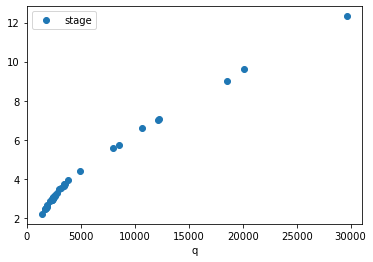

In [3]:
df = pd.read_csv('../data/green_channel.csv'); segments=2 # TRY WITH 3
#df = pd.read_csv('../data/provo_natural.csv'); segments=1
#df = pd.read_csv('../data/co_channel.csv'); segments=1

df = df.sort_values(by='q') #XXX sort or plotting goes crazy
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)
q_sigma = df['q_sigma'].values.reshape(-1,1)

fig, ax = plt.subplots()
df.plot(x='q',y='stage', ax=ax, marker='o', ls='')

In [4]:
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   #q_sigma = q_sigma, not working
                                   q_sigma = None,
                                   prior = {'distribution':'uniform'})

In [13]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=100_000)

Finished [100%]: Average Loss = -42.774


In [14]:
trace = mean_field.sample(5000)

In [15]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.185,0.006,1.175,1.196,0.000,0.0,4742.0,4326.0,NaN
w[1],0.447,0.007,0.433,0.460,0.000,0.0,4848.0,5067.0,NaN
a,-1.190,0.006,-1.201,-1.179,0.000,0.0,4563.0,4678.0,NaN
sigma,0.033,0.004,0.025,0.041,0.000,0.0,4761.0,4412.0,NaN
hs[0],1.238,0.009,1.220,1.256,0.000,0.0,4908.0,4821.0,NaN
hs[1],3.547,0.045,3.462,3.630,0.001,0.0,5073.0,4861.0,NaN


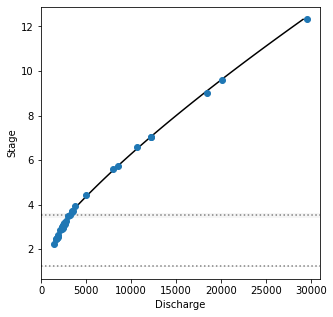

In [16]:
plot_power_law_rating2(powerrating,  trace, None)

In [50]:
# what happens if we choose a different number of segments?

In [11]:
# demo NUTS
n = 4
with powerrating:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 122 seconds.
There were 607 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0227, but should be close to 0.95. Try to increase the number of tuning steps.


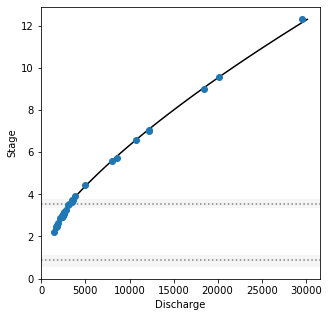

In [12]:
plot_power_law_rating2(powerrating,  trace, None)

# Synthetic Data

<AxesSubplot:xlabel='q', ylabel='stage'>

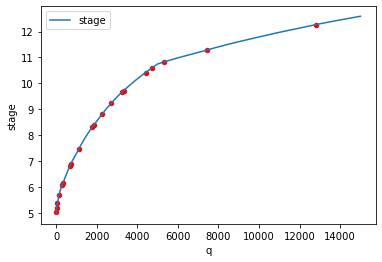

In [28]:
n = 20; segments=3
sim_df = pd.read_csv('../data/simulated_rating.csv')
df = sim_df.sample(n) #works at 200
df = df.sort_values(by='q') #XXX sort or plotting goes crazy
fig, ax = plt.subplots()
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)
sim_df.plot(x='q',y='stage', ax=ax)#, marker='.')

df.plot.scatter(x='q',y='stage', marker='o', color='red', ax=ax)

In [29]:
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   #q_sigma = q_sigma,
                                   q_sigma = None,
                                   prior = {'distribution':'uniform'})


In [ ]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=250_000)
    # increase n for smaller samples (250_000)
    
trace = mean_field.sample(5000)

In [ ]:
# advi 
az.summary(trace, var_names=["w","a","sigma","hs"])

In [ ]:
plot_power_law_rating2(powerrating,  trace, None)

ADVI seems to underestimate uncertainty. NUTS gives better results but will be substantially slower for multiple segments.

In [49]:
n = 4
with powerrating:
    trace = pm.sample(tune=3000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 406 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [50]:
# NUTS
az.summary(trace, var_names=["w","a","sigma","hs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.948,0.049,1.859,2.045,0.002,0.001,757.0,710.0,1.00
w[1],0.204,0.124,0.058,0.456,0.005,0.004,564.0,671.0,1.00
w[2],0.420,0.127,0.161,0.568,0.005,0.004,561.0,863.0,1.00
a,-2.853,0.105,-3.059,-2.659,0.004,0.003,758.0,683.0,1.00
sigma,0.005,0.001,0.002,0.007,0.000,0.000,850.0,1148.0,1.00
hs[0],4.528,0.075,4.373,4.661,0.003,0.002,759.0,674.0,1.00
hs[1],9.891,0.293,9.338,10.231,0.012,0.009,571.0,1393.0,1.01
hs[2],10.940,0.221,10.698,11.450,0.010,0.007,638.0,647.0,1.00


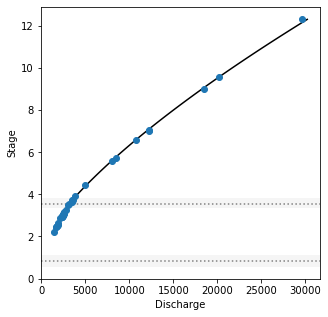

In [84]:
plot_power_law_rating2(powerrating,  trace, None)

#  Notes
This notebook demonstrates the segmented power law. Sometimes other models may work better.

Thanks to the USGS workflow, we can choose any model $f()$ for fitting a particular rating...

\begin{align}
q = f(\theta,s)
\end{align}
where f is the functional form of the rating: power law, spline, NN, etc.

Rather than use this function directly, USGS discritizes $q$
\begin{align}
d(f(\theta,s)) = \begin{bmatrix} s & \hat q \end{bmatrix}
\end{align}
and the discritized form is saved



1. To develop a rating, select a set of observations ($q_1$,$s_1$) and weights $w_1$, fit a rating model and  discritize to yield $\hat q_1$.

1. At a later point in time, develop a new rating from another (perhaps overlapping) set of observations ($q_2$, $s_2$, $w_2$) and discritize as $\hat q_2$.

1. As we accrue more ratings, we form a matrix $q_{ij}$, where $i$ is the rating and $j$ is the stage index. Flow at a particular time and stage ($t$,$s$) is estimated by interpolating between elements in this matrix.

1. After many ratings, we can apply Greg's approach to compute shift uncertainty at each stage $q_{,j}$.

# Scratch